In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.impute import KNNImputer

/tmp/ipykernel_2193955/3939898443.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Preprocessing

In [41]:
# read in data from all three visits
olink_i0 = pd.read_csv("Data/Olink_UKBB_packageDataFreeze_19Jan2024/67864_olink_0_Instance0_all-info.tab", sep = "\t", low_memory=False)
#olink_i2 = pd.read_csv("Data/Olink_UKBB_packageDataFreeze_19Jan2024/67864_olink_0_Instance2_all-info.tab", sep = "\t", low_memory=False)
#olink_i3 = pd.read_csv("Data/Olink_UKBB_packageDataFreeze_19Jan2024/67864_olink_0_Instance3_all-info.tab", sep = "\t", low_memory=False)

In [3]:
# drop values from i0 in i2 and i3 (something went wrong with joining)
olink_i2 = olink_i2.dropna(subset = ['PlateID'])
olink_i3 = olink_i3.dropna(subset = ['PlateID'])

In [4]:
# create participants by protein table
olink_i0_ap = olink_i0.pivot(columns = 'Assay',  values = "NPX",  index = "eid") 

In [5]:
# thresholds for excluding participants/proteins based on amount of nans
t_nan_prot = 0.02
t_nan_part = 0.02


nan_part = olink_i0_ap.isna().sum(axis=1)
nan_part = nan_part.sort_values(ascending=False)

n_proteins = olink_i0_ap.shape[1]


#first discard participants
excluded_participants = nan_part[nan_part > t_nan_part * n_proteins]
olink_i0_parts_dropped = olink_i0_ap.dropna(axis = 0, thresh = (1 - t_nan_part) * n_proteins)


# count nan values per protein and per participant
nan_prot = olink_i0_parts_dropped.isna().sum()
nan_prot = nan_prot.sort_values(ascending=False)

# then discard proteins
n_participants_left = olink_i0_parts_dropped.shape[0]
excluded_proteins = nan_prot[nan_prot > t_nan_prot * n_participants_left].keys()
olink_i0_nansdropped = olink_i0_parts_dropped.dropna(axis = 1, thresh=(1 - t_nan_prot) * n_participants_left)
# olink_i0_nansdropped = olink_i0_nansdropped.dropna(axis = 0, thresh = (1 - t_nan_part) * n_proteins)

print(f'amount of proteins excluded :{len(excluded_proteins)}')
print(f'amount of participants excluded :{len(excluded_participants)}')

amount of proteins excluded :36
amount of participants excluded :11003


In [6]:
## impute data for other missing values
n_n = 5
imputer = KNNImputer(n_neighbors = n_n)
olink_i0_ap_imputed = imputer.fit_transform(olink_i0_nansdropped)

In [7]:
proteins_imputed_df = pd.DataFrame(data = olink_i0_ap_imputed, columns = olink_i0_nansdropped.columns, index = olink_i0_nansdropped.index)
proteins_imputed_df.shape

(41701, 1427)

In [10]:
# find participants for whom we have data in i2/i3 and i0
olink_i0i2_overlap = np.intersect1d(olink_i0_nansdropped.index,  olink_i2['eid'].unique())
olink_i0i3_overlap = np.intersect1d(olink_i0_nansdropped.index,  olink_i3['eid'].unique())

# create set for whom we have 
olink_i0_excl_tmp = proteins_imputed_df[~proteins_imputed_df.index.isin(olink_i0i2_overlap)]
olink_i0_excl = olink_i0_excl_tmp[~olink_i0_excl_tmp.index.isin(olink_i0i3_overlap)]

In [11]:
olink_i0i3_overlap.shape

(897,)

In [ ]:
# create set of longitudinal eids (maybe?)

In [12]:
olink_i0_excl.shape

(40696, 1427)

In [5]:
# count amount of participants for who we are under the lower limit of detection
proteins = olink_i0_excl['Assay'].unique()

LLoD_counts = np.zeros(len(proteins))

for i,  protein in tqdm(enumerate(proteins[:100])):
    protein_subset = olink_i0_excl.loc[(olink_i0_excl['Assay'] == protein)]
    # LLoD_counts[i] = (protein_subset[LOD] > protein_subset[NPX]).sum()
    LLoD_counts[i],  _ = np.where(protein_subset[LOD].values > protein_subset[NPX].values)

0it [00:03, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

<BarContainer object of 100 artists>

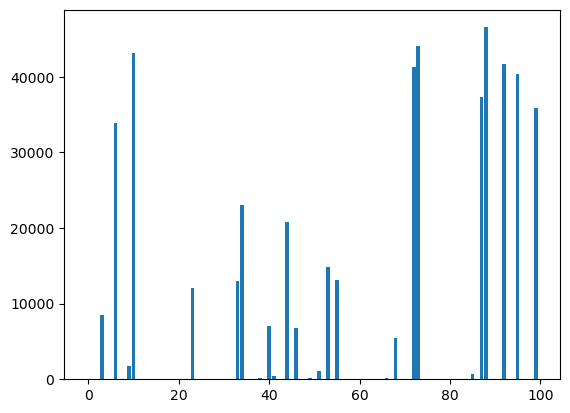

In [85]:
plt.bar(np.arange(len(LLoD_counts))[:100],  LLoD_counts[:100]) 

In [23]:
# create participants by protein table
olink_i0_ap = olink_i0_excl.pivot(columns = 'Assay',  values = "NPX",  index = "eid") 

In [50]:
olink_i0_ap.columns[0:100]

Index(['AARSD1', 'ABHD14B', 'ABL1', 'ACAA1', 'ACAN', 'ACE2', 'ACOX1', 'ACP5',
       'ACP6', 'ACTA2', 'ACTN4', 'ACVRL1', 'ACY1', 'ADA', 'ADA2', 'ADAM15',
       'ADAM22', 'ADAM23', 'ADAM8', 'ADAMTS13', 'ADAMTS15', 'ADAMTS16',
       'ADAMTS8', 'ADCYAP1R1', 'ADGRB3', 'ADGRE2', 'ADGRE5', 'ADGRG1',
       'ADGRG2', 'ADH4', 'ADM', 'AFP', 'AGER', 'AGR2', 'AGR3', 'AGRN', 'AGRP',
       'AGXT', 'AHCY', 'AHSP', 'AIF1', 'AIFM1', 'AK1', 'AKR1B1', 'AKR1C4',
       'AKT1S1', 'AKT3', 'ALCAM', 'ALDH1A1', 'ALDH3A1', 'ALPP', 'AMBN', 'AMBP',
       'AMFR', 'AMIGO2', 'AMN', 'AMY2A', 'AMY2B', 'ANG', 'ANGPT1', 'ANGPT2',
       'ANGPTL1', 'ANGPTL2', 'ANGPTL3', 'ANGPTL4', 'ANGPTL7', 'ANKRD54',
       'ANPEP', 'ANXA10', 'ANXA11', 'ANXA3', 'ANXA4', 'ANXA5', 'AOC1', 'AOC3',
       'APBB1IP', 'APEX1', 'APLP1', 'APOH', 'APOM', 'APP', 'APRT', 'AREG',
       'ARG1', 'ARHGAP1', 'ARHGAP25', 'ARHGEF12', 'ARID4B', 'ARNT', 'ARSA',
       'ARSB', 'ART3', 'ARTN', 'ASAH2', 'ASGR1', 'ATF2', 'ATG4A', 'ATOX1',
       'ATP5IF

In [6]:
print(olink_i0_ap.shape)
olink_i0_ap.head()

(51494, 1463)


Assay    AARSD1  ABHD14B    ABL1   ACAA1    ACAN     ACE2   ACOX1    ACP5  \
eid                                                                         
1000041  0.3476  -0.1879 -0.3896  0.1511  0.5124 -0.28310  0.2759 -0.3092   
1000059  0.4166   0.8393  2.0818  1.2678 -0.0384 -0.19625  1.0011 -0.3905   
1000086  0.7667   0.1949 -0.5907 -2.0024  0.1910  0.05565 -0.5210 -0.0292   
1000181 -0.4305  -0.3222 -0.3300 -0.5217 -0.4388 -0.33185 -0.3997 -0.4358   
1000202 -0.9652      NaN  0.1115 -0.4334 -0.5558 -0.47700 -0.6717 -0.1680   

Assay      ACP6   ACTA2  ...   WNT9A    WWP2    XCL1      XG  XPNPEP2  \
eid                      ...                                            
1000041 -0.2001 -0.3444  ... -0.1501  0.1150 -1.1485 -0.1583   1.0802   
1000059  0.8287  1.1382  ...  0.0244  1.3986 -0.5011 -0.1470  -2.0246   
1000086 -0.3807 -0.3239  ... -0.1429 -0.4454  0.2656 -0.1033   1.5979   
1000181  0.0848  0.0293  ... -0.0308 -0.0307  0.3940  0.1194  -0.8755   
1000202 -1.2523  0.7740  ...     NaN     NaN -0.1239  0.0884   0.5496   

Assay      XRCC4    YES1   YTHDF3   ZBTB16  ZBTB17  
eid                                                 
1000041  0.00705 -0.5165 -0.20180 -0.39815 -0.7475  
1000059  0.69135  2.9295  1.70705  2.09095 -0.0563  
1000086 -0.83675 -1.1427 -1.48585 -0.55125 -0.0230  
1000181  0.18495 -0.2938 -0.43035 -0.27505 -0.4865  
1000202  0.19695 -0.1406      NaN -0.10215 -0.0632  

[5 rows x 1463 columns]

In [73]:
# print(f'total nans before replacement: {olink_i0_ap.isna().sum().sum()}')
# #replace values more than 5 standard deviations from the mean with nan
# # this is not required, already done by UKBB
# for col in olink_i0_ap.columns:
#     col_std = olink_i0_ap[col].std()
#     col_mean = olink_i0_ap[col].mean()
#     olink_i0_ap[col].loc[(olink_i0_ap[col] > (col_mean + 5 * col_std)) | (olink_i0_ap[col] < (col_mean - 5 * col_std))] = np.nan
# print(f'total nans after replacement: {olink_i0_ap.isna().sum().sum()}')


total nans before replacement: 2181637


/tmp/ipykernel_536857/1266645818.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  olink_i0_ap[col].loc[(olink_i0_ap[col] > (col_mean + 5 * col_std)) | (olink_i0_ap[col] < (col_mean - 5 * col_std))] = np.nan


total nans after replacement: 2270932


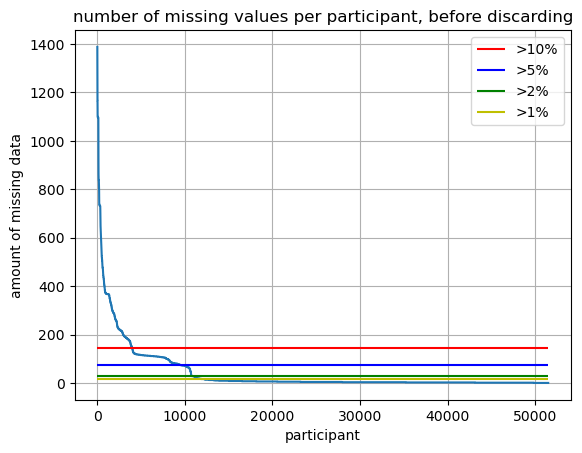

In [24]:
nan_part = olink_i0_ap.isna().sum(axis=1)
nan_part = nan_part.sort_values(ascending=False)

plt.plot(np.arange(len(nan_part)), nan_part.values)
plt.xlabel("participant")
plt.ylabel("amount of missing data")
plt.grid()
plt.hlines(olink_i0_ap.shape[1] * 0.10, 0, olink_i0_ap.shape[0], label = ">10%", color = "r")
plt.hlines(olink_i0_ap.shape[1] * 0.05, 0, olink_i0_ap.shape[0], label = ">5%", color = "b")
plt.hlines(olink_i0_ap.shape[1] * 0.02, 0, olink_i0_ap.shape[0], label = ">2%", color = "g")
plt.hlines(olink_i0_ap.shape[1] * 0.01, 0, olink_i0_ap.shape[0], label = ">1%", color = "y")
plt.title("number of missing values per participant, before discarding")
plt.legend()

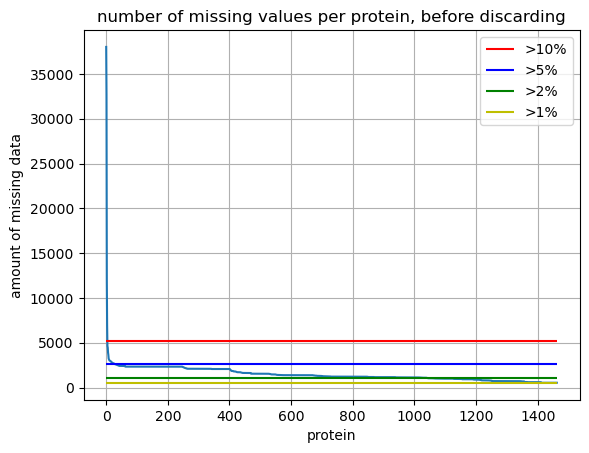

In [28]:
nan_part = olink_i0_ap.isna().sum(axis=0)
nan_part = nan_part.sort_values(ascending=False)

plt.plot(np.arange(len(nan_part)), nan_part.values)
plt.xlabel("protein")
plt.ylabel("amount of missing data")
plt.grid()
plt.hlines(olink_i0_ap.shape[0] * 0.10, 0, nan_part.shape[0], label = ">10%", color = "r")
plt.hlines(olink_i0_ap.shape[0] * 0.05, 0, nan_part.shape[0], label = ">5%", color = "b")
plt.hlines(olink_i0_ap.shape[0] * 0.02, 0, nan_part.shape[0], label = ">2%", color = "g")
plt.hlines(olink_i0_ap.shape[0] * 0.01, 0, nan_part.shape[0], label = ">1%", color = "y")
plt.title("number of missing values per protein, before discarding")
plt.legend()

In [26]:
nan_part.shape

(1463,)

Text(0.5, 1.0, 'number of missing values per protein (after discarding participants with >2% missing values)')

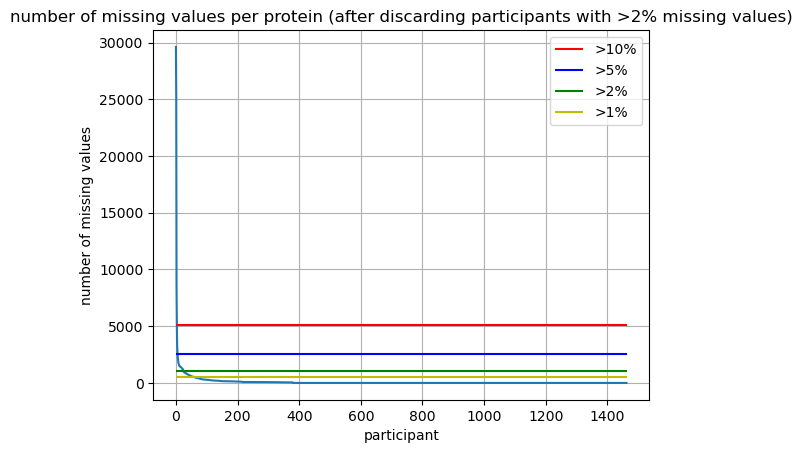

In [19]:
nan_prot_parts_dropped = olink_i0_nansdropped.isna().sum()
nan_prot_parts_dropped = nan_prot_parts_dropped.sort_values(ascending=False)
# nan_prot_parts_dropped = nan_prot_parts_dropped[:200]

nan_prot_parts_dropped.plot.line()
plt.ylabel("number of missing values")
plt.xlabel("participant")
plt.hlines(olink_i0_ap.shape[0] * 0.10, 0, nan_prot_parts_dropped.shape[0], label = ">10%", color = "r")
plt.hlines(olink_i0_ap.shape[0] * 0.05, 0, nan_prot_parts_dropped.shape[0], label = ">5%", color = "b")
plt.hlines(olink_i0_ap.shape[0] * 0.02, 0, nan_prot_parts_dropped.shape[0], label = ">2%", color = "g")

plt.hlines(olink_i0_ap.shape[0] * 0.01, 0, nan_prot_parts_dropped.shape[0], label = ">1%", color = "y")

plt.xticks(np.arange(0, nan_prot_parts_dropped.shape[0], step=200), np.arange(0, nan_prot_parts_dropped.shape[0], step=200))
plt.legend()
plt.grid()
plt.title("number of missing values per protein (after discarding participants with >2% missing values)")

In [24]:
excluded_proteins

Index(['NPM1', 'PCOLCE', 'CTSS', 'TACSTD2', 'AMY2B', 'CTSD', 'KRT14', 'WFDC2',
       'GKN1', 'AMY2A', 'CD93', 'MMP1', 'ISLR2', 'CD59', 'CEACAM5', 'CD55',
       'EPHA2', 'CDH1', 'LPO', 'KLK8', 'AGR2', 'AZU1', 'ENPP7', 'GP2', 'LAMP2',
       'LCN2', 'GSTP1', 'TIA1', 'SERPINA12', 'CRNN', 'COMT', 'HSP90B1'],
      dtype='object', name='Assay')

In [21]:
nancols, nanrows = np.where(olink_i0_nansdropped.isna())

# olink_i0_nansdropped[pd.isnull(olink_i0_nansdropped)]

In [22]:
all_changed_values_diff = np.zeros(len(nancols))
for i, (nancol, nanrow) in enumerate(zip(nancols, nanrows)):
    all_changed_values_diff[i] = olink_i0_ap_imputed[nancol, nanrow] - olink_i0_nansdropped.iloc[nancol, :].mean()


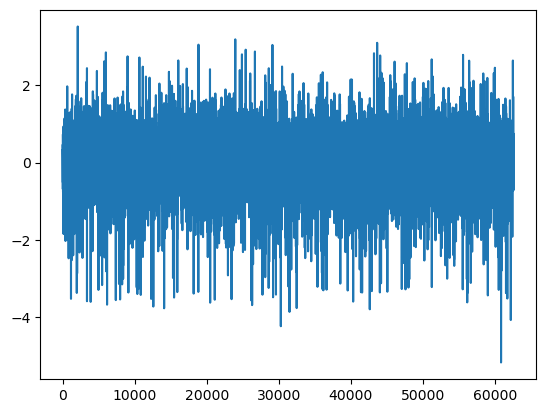

In [23]:
plt.plot(np.arange(len(all_changed_values_diff)), all_changed_values_diff)

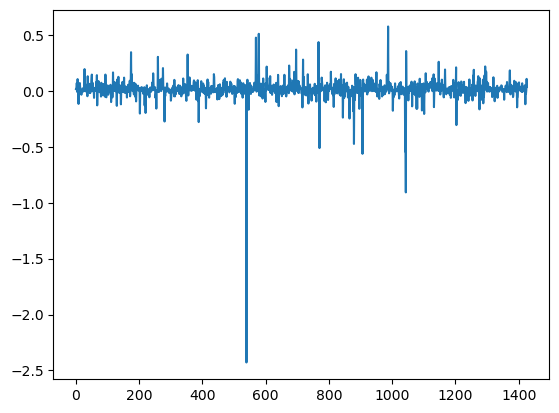

In [24]:
plt.plot(np.arange(len(olink_i0_nansdropped.columns)), olink_i0_nansdropped.mean())

In [25]:
proteins_final_df = pd.DataFrame(data = olink_i0_ap_imputed, columns = olink_i0_nansdropped.columns, index = olink_i0_nansdropped.index)
proteins_final_df.head()

Assay    AARSD1  ABHD14B    ABL1   ACAA1    ACAN     ACE2   ACOX1    ACP5  \
eid                                                                         
1000041  0.3476  -0.1879 -0.3896  0.1511  0.5124 -0.28310  0.2759 -0.3092   
1000059  0.4166   0.8393  2.0818  1.2678 -0.0384 -0.19625  1.0011 -0.3905   
1000086  0.7667   0.1949 -0.5907 -2.0024  0.1910  0.05565 -0.5210 -0.0292   
1000181 -0.4305  -0.3222 -0.3300 -0.5217 -0.4388 -0.33185 -0.3997 -0.4358   
1000345  0.3191   0.5591  0.4769 -0.2783  0.2849  0.16560  0.0844 -0.0938   

Assay      ACP6   ACTA2  ...   WNT9A    WWP2    XCL1      XG  XPNPEP2  \
eid                      ...                                            
1000041 -0.2001 -0.3444  ... -0.1501  0.1150 -1.1485 -0.1583   1.0802   
1000059  0.8287  1.1382  ...  0.0244  1.3986 -0.5011 -0.1470  -2.0246   
1000086 -0.3807 -0.3239  ... -0.1429 -0.4454  0.2656 -0.1033   1.5979   
1000181  0.0848  0.0293  ... -0.0308 -0.0307  0.3940  0.1194  -0.8755   
1000345  0.0633 -0.0207  ...  0.0618  0.3204 -0.3574 -0.5261  -0.3112   

Assay      XRCC4    YES1   YTHDF3   ZBTB16  ZBTB17  
eid                                                 
1000041  0.00705 -0.5165 -0.20180 -0.39815 -0.7475  
1000059  0.69135  2.9295  1.70705  2.09095 -0.0563  
1000086 -0.83675 -1.1427 -1.48585 -0.55125 -0.0230  
1000181  0.18495 -0.2938 -0.43035 -0.27505 -0.4865  
1000345 -0.18660  1.0092  0.96570  0.36930  0.3052  

[5 rows x 1427 columns]

In [26]:
proteins_final_df.shape

(41701, 1427)

In [13]:
np.savetxt("eids_proteins.csv", olink_i0_excl.index)

In [14]:
proteins_final_df = olink_i0_excl

## split in train/validate/test

In [15]:
# we split into 70% train, 20% validate and 10% test
# we first create the protein + metabolomics set, then we add protein data to each set to create the protein-only dataset

# read in eids
mb_eids = np.genfromtxt("Data/NMR_ids.csv")
prot_eids = proteins_final_df.index.values

# find overlapping set
overlapping_ids, mb_idx, prot_idx = np.intersect1d(mb_eids, prot_eids, return_indices = True)

# create 70/20/10 split in the overlapping set
# shuffle and split
rng = np.random.default_rng(seed = 42)
rng.shuffle(overlapping_ids)
train_cutoff = math.floor(0.7 * len(overlapping_ids))
val_cutoff = math.floor(0.9 * len(overlapping_ids))
combined_train = overlapping_ids[:train_cutoff]
combined_val = overlapping_ids[train_cutoff:val_cutoff]
combined_test = overlapping_ids[val_cutoff:]

In [16]:
# create protein-only set
# we combine this with the combined set to train olink-only models (this is just an easy way to create that set)

# remove combined eid
prot_only_eids = np.delete(prot_eids, prot_idx)

# create 70/20/10 split in the protein only set
# shuffle and split
rng = np.random.default_rng(seed = 42)
rng.shuffle(overlapping_ids)
train_cutoff = math.floor(0.7 * len(prot_only_eids))
val_cutoff = math.floor(0.9 * len(prot_only_eids))
prot_only_train = prot_only_eids[:train_cutoff]
prot_only_val = prot_only_eids[train_cutoff:val_cutoff]
prot_only_test = prot_only_eids[val_cutoff:]

In [17]:
# combine for full protein test/train/val sets
full_train_eids = np.concatenate((prot_only_train, combined_train))
full_test_eids = np.concatenate((prot_only_test, combined_test))
full_val_eids = np.concatenate((prot_only_val, combined_val))

In [18]:
len(full_train_eids), len(full_test_eids), len(full_val_eids),

(28487, 4071, 8138)

In [19]:
# save subset eids
# naming convention:
# - full: combination of subsets with and without metabolites
# - prot_only: subset without metabolites
# - combined: subset with metabolites

np.savetxt("full_train_eids.csv", full_train_eids)
np.savetxt("full_test_eids.csv", full_test_eids)
np.savetxt("full_val_eids.csv", full_val_eids)

np.savetxt("prot_only_train_eids.csv", prot_only_train)
np.savetxt("prot_only_test_eids.csv", prot_only_test)
np.savetxt("prot_only_val_eids.csv", prot_only_val)

np.savetxt("combined_train_eids.csv", combined_train)
np.savetxt("combined_test_eids.csv", combined_test)
np.savetxt("combined_val_eids.csv", combined_val)


In [36]:
# load eids
full_train_eids = np.genfromtxt("full_train_eids.csv").astype(np.uint64)
full_test_eids = np.genfromtxt("full_test_eids.csv").astype(np.uint64)
full_val_eids = np.genfromtxt("full_val_eids.csv").astype(np.uint64)


combined_train_eids = np.genfromtxt("combined_train_eids.csv").astype(np.uint64)
combined_test_eids = np.genfromtxt("combined_test_eids.csv").astype(np.uint64)
combined_val_eids = np.genfromtxt("combined_val_eids.csv").astype(np.uint64)

In [37]:
full_train_eids[0]

1000041

In [35]:
proteins_final_df.index[0]

1000041

In [33]:
proteins_final_df = pd.read_csv("proteins_UKBB_imputed.csv", index_col = "eid")
proteins_final_df.head()

AARSD1  ABHD14B    ABL1   ACAA1    ACAN     ACE2   ACOX1    ACP5  \
eid                                                                         
1000041  0.3476  -0.1879 -0.3896  0.1511  0.5124 -0.28310  0.2759 -0.3092   
1000059  0.4166   0.8393  2.0818  1.2678 -0.0384 -0.19625  1.0011 -0.3905   
1000086  0.7667   0.1949 -0.5907 -2.0024  0.1910  0.05565 -0.5210 -0.0292   
1000181 -0.4305  -0.3222 -0.3300 -0.5217 -0.4388 -0.33185 -0.3997 -0.4358   
1000345  0.3191   0.5591  0.4769 -0.2783  0.2849  0.16560  0.0844 -0.0938   

           ACP6   ACTA2  ...   WNT9A    WWP2    XCL1      XG  XPNPEP2  \
eid                      ...                                            
1000041 -0.2001 -0.3444  ... -0.1501  0.1150 -1.1485 -0.1583   1.0802   
1000059  0.8287  1.1382  ...  0.0244  1.3986 -0.5011 -0.1470  -2.0246   
1000086 -0.3807 -0.3239  ... -0.1429 -0.4454  0.2656 -0.1033   1.5979   
1000181  0.0848  0.0293  ... -0.0308 -0.0307  0.3940  0.1194  -0.8755   
1000345  0.0633 -0.0207  ...  0.0618  0.3204 -0.3574 -0.5261  -0.3112   

           XRCC4    YES1   YTHDF3   ZBTB16  ZBTB17  
eid                                                 
1000041  0.00705 -0.5165 -0.20180 -0.39815 -0.7475  
1000059  0.69135  2.9295  1.70705  2.09095 -0.0563  
1000086 -0.83675 -1.1427 -1.48585 -0.55125 -0.0230  
1000181  0.18495 -0.2938 -0.43035 -0.27505 -0.4865  
1000345 -0.18660  1.0092  0.96570  0.36930  0.3052  

[5 rows x 1428 columns]

In [39]:
# use eids to create datasplits for protein data
full_train_df = proteins_final_df.loc[full_train_eids]
full_test_df = proteins_final_df.loc[full_test_eids]
full_val_df = proteins_final_df.loc[full_val_eids]

combined_train_df = proteins_final_df.loc[combined_train_eids]
combined_test_df = proteins_final_df.loc[combined_test_eids]
combined_val_df = proteins_final_df.loc[combined_val_eids]

In [46]:
olink_i0.head()

eid    Assay     NPX            Panel Panel_Lot_Nr  Assay_Version  \
0  1000181   AARSD1 -0.4305         Oncology       B04412            1.0   
1  1000181  ABHD14B -0.3222        Neurology       B04414            1.0   
2  1000181     ABL1 -0.3300         Oncology       B04412            1.0   
3  1000181    ACAA1 -0.5217         Oncology       B04412            1.0   
4  1000181     ACAN -0.4388  Cardiometabolic       B04413            1.0   

        PlateID WellID  Batch     LOD Processing_StartDate  Instance  
0  8.900000e+11    D08    3.0 -5.1861           2021-08-26         0  
1  8.900000e+11    D08    3.0 -4.1701           2021-08-26         0  
2  8.900000e+11    D08    3.0 -4.3769           2021-08-26         0  
3  8.900000e+11    D08    3.0 -1.2737           2021-08-26         0  
4  8.900000e+11    D08    3.0 -3.4464           2021-08-26         0

In [42]:
# determine olink proteins
olink_prots = olink_i0.loc[olink_i0['Panel'] == "Cardiometabolic"]['Assay'].unique()

In [22]:
len(olink_prots)

366

In [43]:
olink_prots_not_discarded = np.intersect1d(olink_prots, full_train_df.columns)

In [24]:
len(olink_prots_not_discarded)

344

In [44]:
# create different set with VOILA olink-only proteins
full_train_cmb = full_train_df[olink_prots_not_discarded]
full_test_cmb = full_test_df[olink_prots_not_discarded]
full_val_cmb = full_val_df[olink_prots_not_discarded]

combined_train_cmb = combined_train_df[olink_prots_not_discarded]
combined_test_cmb = combined_test_df[olink_prots_not_discarded]
combined_val_cmb = combined_val_df[olink_prots_not_discarded]

In [26]:
full_train_olink.shape

(28487, 344)

In [45]:
# save to csv
full_train_df.to_csv("full_train.csv")
full_test_df.to_csv("full_test.csv")
full_val_df.to_csv("full_val.csv")

combined_train_df.to_csv("combined_train.csv")
combined_test_df.to_csv("combined_test.csv")
combined_val_df.to_csv("combined_val.csv")

In [46]:
# save to csv
full_train_cmb.to_csv("full_train_cmb.csv")
full_test_cmb.to_csv("full_test_cmb.csv")
full_val_cmb.to_csv("full_val_cmb.csv")

combined_train_cmb.to_csv("combined_train_cmb.csv")
combined_test_cmb.to_csv("combined_test_cmb.csv")
combined_val_cmb.to_csv("combined_val_cmb.csv")

In [84]:
full_train_cmb.shape

(28487, 344)

### create CMB_met set 3

In [6]:
# read in set3 proteins and metabolites
set3_prots_df = pd.read_csv("Data/Processed/Combined/combined_test_cmb.csv")
metabolites = pd.read_csv("Data/NMR_NotDerived.csv")

In [9]:
full_set3_cmb_met = set3_prots_df.merge(metabolites, on = "eid")

In [10]:
full_set3_cmb_met.head()

eid     ACAN     ACE2   ACOX1    ACP5    ACTA2     ACY1    ADA2  \
0  4772956 -0.22300 -0.60865 -0.2074 -0.3371  1.02525 -0.24335  0.7321   
1  4005228 -0.45760  0.05955  0.0455 -0.0814 -0.44310  0.78030 -0.1580   
2  3326876  0.58275 -0.07160  0.0768  0.2348 -0.00955 -0.04990  0.3341   
3  4029114 -0.14660  0.78955  0.3804 -0.2721  1.70425  0.26795 -0.0137   
4  3669187  0.35520 -0.39615 -0.3088 -0.0844  0.43295 -0.90705 -0.2402   

    ADAM15  ADAMTS13  ...   M_HDL_P  M_HDL_PL  M_HDL_CE  M_HDL_FC  M_HDL_TG  \
0  0.15585  -0.21655  ...  0.003750   0.46456   0.41729  0.086536  0.036401   
1  0.32725   0.40135  ...  0.003240   0.45024   0.30443  0.074768  0.077850   
2 -0.04225  -0.11285  ...  0.003999   0.49894   0.38884  0.090639  0.083045   
3  0.25075  -0.44435  ...  0.002909   0.39020   0.30857  0.057776  0.054382   
4  0.10675   0.09125  ...  0.004980   0.58438   0.52185  0.118730  0.055923   

    S_HDL_P  S_HDL_PL  S_HDL_CE  S_HDL_FC  S_HDL_TG  
0  0.010135   0.65020   0.35427   0.11872  0.041808  
1  0.009592   0.68213   0.30126   0.12083  0.085760  
2  0.011009   0.75163   0.35703   0.13622  0.083487  
3  0.009046   0.62288   0.30675   0.10122  0.060592  
4  0.009424   0.66612   0.31398   0.12127  0.041309  

[5 rows x 452 columns]

In [11]:
# verify ordering is the same
set1_cmb_met = pd.read_csv("Data/proteins_metabolites_train.csv")

In [12]:
set1_cmb_met.head()

eid     ACAN     ACE2   ACOX1    ACP5    ACTA2    ACY1    ADA2  \
0  1004826.0  0.26630 -0.64465 -0.1113  0.0438 -0.51390 -0.2660 -0.6083   
1  1008846.0  0.19890 -0.44540  0.3539 -0.3612 -0.80070 -0.2898 -0.3670   
2  1009759.0  0.47385  0.28980  0.5944  0.4084  0.14695  0.4389 -0.0251   
3  1010092.0  0.69300  0.33035 -0.0867  0.1029 -0.21260 -0.9159  0.0941   
4  1013849.0 -0.53495  0.00570 -0.1853 -0.6804 -0.49645 -0.0129 -0.5292   

    ADAM15  ADAMTS13  ...   M_HDL_P  M_HDL_PL  M_HDL_CE  M_HDL_FC  M_HDL_TG  \
0 -0.26415   0.46130  ...  0.004819   0.55127   0.53284  0.117560  0.029189   
1  0.41385  -0.17045  ...  0.003523   0.43707   0.39527  0.078925  0.033742   
2  0.48095   0.88205  ...  0.007907   0.91127   0.82377  0.195110  0.071630   
3  0.32995   0.12015  ...  0.003203   0.41960   0.36262  0.064616  0.040342   
4  0.20735   0.08845  ...  0.005755   0.66316   0.62677  0.136640  0.036597   

    S_HDL_P  S_HDL_PL  S_HDL_CE  S_HDL_FC  S_HDL_TG  
0  0.010283   0.64859   0.35715   0.12610  0.028323  
1  0.010482   0.65564   0.36992   0.11640  0.040201  
2  0.011788   0.89858   0.39433   0.15944  0.040196  
3  0.009473   0.63395   0.33853   0.10004  0.044015  
4  0.009627   0.67864   0.33919   0.11918  0.022416  

[5 rows x 452 columns]

In [18]:
# save csv
full_set3_cmb_met.to_csv("Data/proteins_metabolites_set3.csv")

## create outcome coupling with data splits

In [77]:
# read in full df including mort
basic_info = pd.read_csv("Data/basicinfo_instance_0.csv")

In [48]:
basic_info.head()

eid  sex  died  age_center.0.0 date_center.0.0  hbp.0.0  smoking.0.0  \
0  1000014  0.0     0            63.0      2008-09-13        1          0.0   
1  1000023  0.0     0            57.0      2010-05-12        0          1.0   
2  1000030  1.0     0            40.0      2007-10-18        0          0.0   
3  1000041  1.0     0            65.0      2010-04-15        1          0.0   
4  1000059  1.0     0            50.0      2008-08-06        0          0.0   

   yearbirth  monthbirth mortdate.0.0   followup  
0     1945.0         5.0          NaN  14.264203  
1     1953.0         3.0          NaN  12.605065  
2     1967.0         1.0          NaN  15.170431  
3     1944.0        11.0          NaN  12.678987  
4     1958.0         7.0          NaN  14.368241

In [49]:
basic_info.shape

(502486, 11)

In [58]:
# create left censored data (ignore this)
def create_censor_data(x):
    # print(x)
    if x['died'] == True:
        return (pd.to_datetime(x['mortdate.0.0']) - pd.to_datetime(x['date_center.0.0'])).days / 365.25 + x['age_center.0.0']
    else:
        return x['age_center.0.0'] + x['followup']

basic_info['censorage'] = basic_info.apply(lambda x: create_censor_data(x), axis = 1)


In [59]:
basic_info['censorage'] = basic_info['age_center.0.0'] + basic_info['followup']

In [60]:
np.allclose(basic_info['censorage'].values, basic_info['censorage_alt'].values) 

False

In [73]:
inds = np.where(np.isclose(basic_info['censorage'].values, basic_info['censorage_alt'].values) == False)[0]
inds

array([116921])

In [76]:
basic_info.iloc[inds,:]

eid  sex  died  age_center.0.0 date_center.0.0  hbp.0.0  \
116921  2169224  NaN     0             NaN             NaN        0   

        smoking.0.0  yearbirth  monthbirth mortdate.0.0  followup  censorage  \
116921          NaN        NaN         NaN          NaN       NaN        NaN   

        censorage_alt  
116921            NaN

In [70]:
basic_info.loc[basic_info['died'] == 1].head(30)

eid  sex  died  age_center.0.0 date_center.0.0  hbp.0.0  smoking.0.0  \
25   1000264  1.0     1            69.0      2008-03-12        1          1.0   
37   1000380  1.0     1            61.0      2010-01-25        1          0.0   
40   1000410  0.0     1            64.0      2008-04-12        0          1.0   
50   1000511  0.0     1            64.0      2009-08-20        0          0.0   
98   1000993  1.0     1            69.0      2008-12-16        1          2.0   
111  1001122  1.0     1            69.0      2008-04-21        1          1.0   
138  1001390  1.0     1            62.0      2008-11-25        1          2.0   
142  1001432  0.0     1            68.0      2009-12-01        1          0.0   
160  1001615  1.0     1            66.0      2009-06-20        1          1.0   
162  1001631  0.0     1            54.0      2008-05-09        0          0.0   
172  1001733  0.0     1            67.0      2008-05-03        1          1.0   
175  1001766  1.0     1            48.0      2009-01-09        0          0.0   
178  1001792  1.0     1            69.0      2009-03-24        1          0.0   
212  1002139  1.0     1            50.0      2009-12-02        1          0.0   
226  1002272  0.0     1            58.0      2009-12-16        1          0.0   
231  1002323  0.0     1            66.0      2008-04-18        1          0.0   
241  1002420  0.0     1            64.0      2008-10-08        1          1.0   
249  1002502  1.0     1            65.0      2008-09-09        0          0.0   
262  1002634  1.0     1            60.0      2009-07-02        0          2.0   
275  1002769  1.0     1            60.0      2009-09-30        0          2.0   
280  1002819  0.0     1            66.0      2009-06-02        0          0.0   
283  1002848  0.0     1            54.0      2009-02-24        0          1.0   
284  1002854  0.0     1            60.0      2008-01-24        0          2.0   
296  1002970  1.0     1            67.0      2010-03-11        1          0.0   
298  1002992  1.0     1            60.0      2008-09-22        0          2.0   
300  1003016  1.0     1            65.0      2008-05-28        1          1.0   
302  1003037  0.0     1            61.0      2009-04-02        0          0.0   
310  1003110  1.0     1            59.0      2007-12-06        1          1.0   
316  1003178  1.0     1            66.0      2010-05-26        1          2.0   
322  1003233  1.0     1            67.0      2009-07-16        1          2.0   

     yearbirth  monthbirth mortdate.0.0   followup  censorage  censorage_alt  
25      1939.0         2.0   2021-03-23  13.029432  82.029432      82.029432  
37      1948.0        11.0   2021-11-14  11.802875  72.802875      72.802875  
40      1943.0        12.0   2018-08-11  10.329911  74.329911      74.329911  
50      1944.0         9.0   2022-05-02  12.698152  76.698152      76.698152  
98      1939.0         7.0   2021-10-13  12.824093  81.824093      81.824093  
111     1938.0        11.0   2020-02-06  11.794661  80.794661      80.794661  
138     1946.0         1.0   2022-07-09  13.618070  75.618070      75.618070  
142     1941.0         4.0   2020-11-25  10.984257  78.984257      78.984257  
160     1943.0         2.0   2021-03-05  11.707050  77.707050      77.707050  
162     1953.0         6.0   2021-10-03  13.401780  67.401780      67.401780  
172     1941.0         4.0   2014-05-23   6.053388  73.053388      73.053388  
175     1960.0         2.0   2021-11-21  12.865161  60.865161      60.865161  
178     1940.0         2.0   2021-02-12  11.890486  80.890486      80.890486  
212     1959.0         2.0   2022-03-11  12.271047  62.271047      62.271047  
226     1951.0        11.0   2020-03-04  10.214921  68.214921      68.214921  
231     1942.0         3.0   2017-12-23   9.681040  75.681040      75.681040  
241     1944.0         2.0   2019-03-19  10.442163  74.442163      74.442163  
249     1943.0         4.0   2016-02-28   7.468857  72.468857      72.46885

In [78]:
basic_info['censorage'] = basic_info['age_center.0.0'] + basic_info['followup']

# select eids we're using (all participants)
train_full_basic = basic_info.loc[basic_info['eid'].isin(full_train_eids)]
test_full_basic = basic_info.loc[basic_info['eid'].isin(full_val_eids)]
val_full_basic = basic_info.loc[basic_info['eid'].isin(full_test_eids)]

# select eids we're using (participants w/ metabolites)
train_combined_basic = basic_info.loc[basic_info['eid'].isin(combined_train_eids)]
test_combined_basic = basic_info.loc[basic_info['eid'].isin(combined_val_eids)]
val_combined_basic = basic_info.loc[basic_info['eid'].isin(combined_test_eids)]

In [85]:
train_combined_basic

eid  sex  died  age_center.0.0 date_center.0.0  hbp.0.0  \
4       1000059  1.0     0            50.0      2008-08-06        0   
109     1001109  0.0     0            45.0      2008-12-05        0   
122     1001230  1.0     0            63.0      2008-02-04        1   
133     1001344  0.0     0            54.0      2008-04-19        0   
137     1001389  0.0     0            63.0      2008-06-05        1   
...         ...  ...   ...             ...             ...      ...   
502328  6023296  0.0     0            61.0      2009-04-04        1   
502361  6023620  1.0     0            50.0      2008-07-30        0   
502395  6023960  0.0     0            41.0      2008-11-22        0   
502409  6024105  1.0     1            58.0      2009-01-22        1   
502473  6024745  0.0     0            42.0      2010-06-25        0   

        smoking.0.0  yearbirth  monthbirth mortdate.0.0   followup  censorage  
4               0.0     1958.0         7.0          NaN  14.368241  64.368241  
109             0.0     1963.0         5.0          NaN  14.036961  59.036961  
122             0.0     1944.0         3.0          NaN  14.872005  77.872005  
133             1.0     1953.0         9.0          NaN  14.666667  68.666667  
137             1.0     1945.0         3.0          NaN  14.537988  77.537988  
...             ...        ...         ...          ...        ...        ...  
502328          0.0     1947.0         9.0          NaN  13.708419  74.708419  
502361          1.0     1958.0         1.0          NaN  14.387406  64.387406  
502395          1.0     1966.0        12.0          NaN  14.072553  55.072553  
502409          1.0     1950.0         5.0   2015-07-06   6.450376  64.450376  
502473          0.0     1968.0         3.0          NaN  12.484600  54.484600  

[15458 rows x 12 columns]

In [86]:
# save to csv
train_full_basic[['eid', 'died', 'censorage', 'sex']].to_csv("mort_full_train.csv")
test_full_basic[['eid', 'died', 'censorage', 'sex']].to_csv("mort_full_test.csv")
val_full_basic[['eid', 'died', 'censorage', 'sex']].to_csv("mort_full_val.csv")

train_combined_basic[['eid', 'died', 'censorage', 'sex']].to_csv("mort_comb_train.csv")
test_combined_basic[['eid', 'died', 'censorage', 'sex']].to_csv("mort_comb_test.csv")
val_combined_basic[['eid', 'died', 'censorage', 'sex']].to_csv("mort_comb_val.csv")

In [32]:
proteins_final_df.isna().sum()

Assay
AARSD1     0
ABHD14B    0
ABL1       0
ACAA1      0
ACAN       0
          ..
XRCC4      0
YES1       0
YTHDF3     0
ZBTB16     0
ZBTB17     0
Length: 1459, dtype: int64

In [130]:
proteins_final_df.to_csv("proteins_UKBB_imputed.csv")

## Visualizations

In [31]:
i0_1pers = olink_i0_excl.loc[olink_i0_excl['eid'] == 1000181]
protein_platform = i0_1pers.loc[i0_1pers['Assay'].isin(excluded_proteins)]

<Axes: xlabel='Panel'>

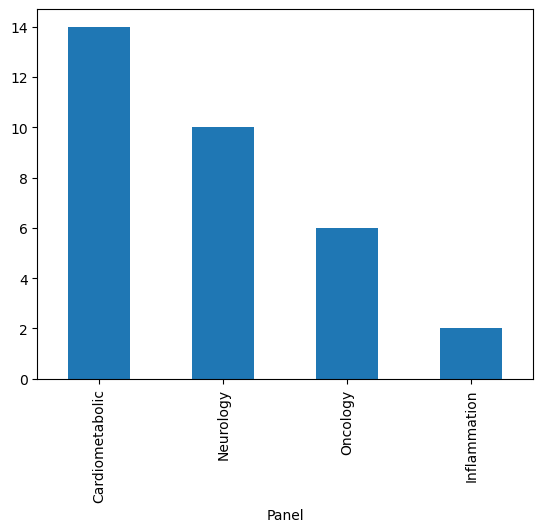

In [42]:
protein_platform['Panel'].value_counts().plot.bar()

In [ ]:
prot0 = olink_i0_ap

In [60]:
olink_i0_ap.shape

(51494, 1463)

Text(0.5, 1.0, 'number of missing values per protein')

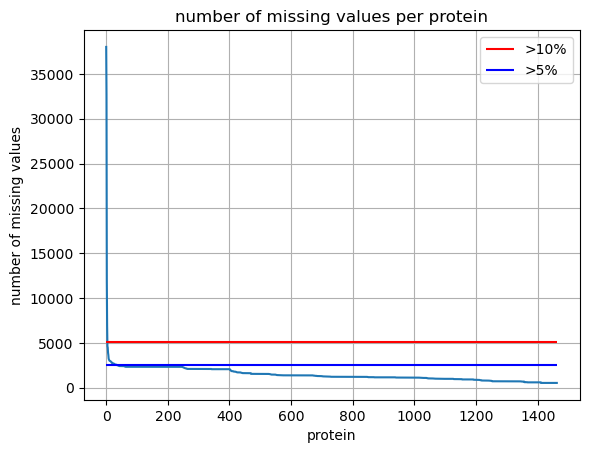

In [9]:
# nan100 = nan_prot.nlargest(50)
nan_prot.plot.line()
plt.ylabel("number of missing values")
plt.xlabel("protein")
plt.hlines(olink_i0_ap.shape[0] * 0.10, 0, nan_prot.shape[0], label = ">10%", color = "r")
plt.hlines(olink_i0_ap.shape[0] * 0.05, 0, nan_prot.shape[0], label = ">5%", color = "b")
plt.xticks(np.arange(0, nan_prot.shape[0], step=200), np.arange(0, nan_prot.shape[0], step=200))
plt.legend()
plt.grid()
plt.title("number of missing values per protein")
# plt.bar(np.arange(100),  nan100.values())
# plt.xlabel([np.arange(100),  nan100.keys()])

Text(0.5, 1.0, 'number of missing values per protein')

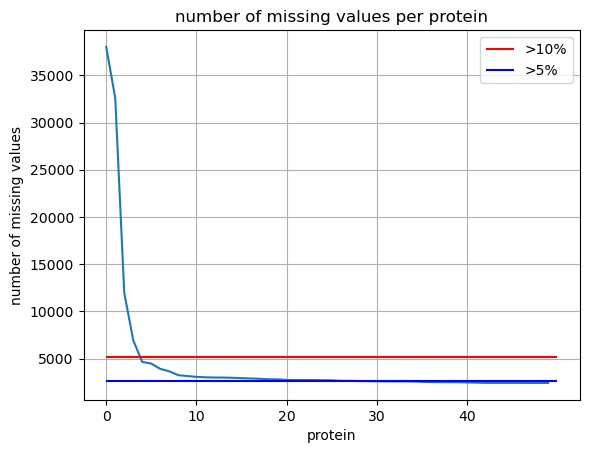

In [10]:
nan100 = nan_prot.nlargest(50)
nan100.plot.line()
plt.ylabel("number of missing values")
plt.xlabel("protein")
plt.hlines(olink_i0_ap.shape[0] * 0.10, 0, nan100.shape[0], label = ">10%", color = "r")
plt.hlines(olink_i0_ap.shape[0] * 0.05, 0, nan100.shape[0], label = ">5%", color = "b")
plt.xticks(np.arange(0, nan100.shape[0], step=10), np.arange(0, nan100.shape[0], step=10))
plt.legend()
plt.grid()
plt.title("number of missing values per protein")
# plt.bar(np.arange(100),  nan100.values())
# plt.xlabel([np.arange(100),  nan100.keys()])

In [13]:
nan_part = olink_i0_ap.isna().sum(axis=1)
nan_part = nan_part.sort_values(ascending=False)

In [65]:
nan_part[nan_part > 0.05 * olink_i0_ap.shape[1]]

eid
1424214    1388
3789349    1358
1733371    1292
1462828    1286
3572441    1286
           ... 
4791011      74
1795167      74
2134254      74
3450218      74
5472819      74
Length: 9531, dtype: int64

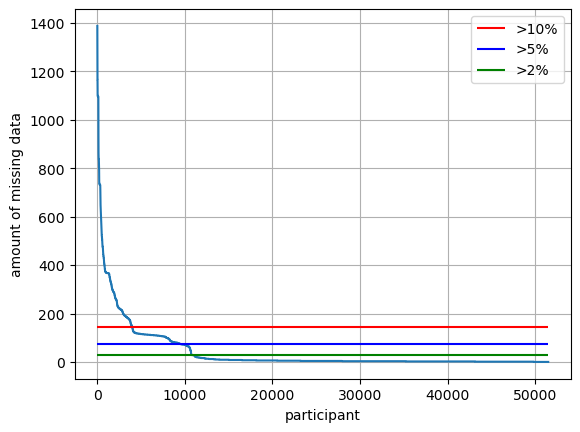

In [14]:
nan_part = olink_i0_ap.isna().sum(axis=1)
nan_part = nan_part.sort_values(ascending=False)

plt.plot(np.arange(len(nan_part)), nan_part.values)
plt.xlabel("participant")
plt.ylabel("amount of missing data")
plt.grid()
plt.hlines(olink_i0_ap.shape[1] * 0.10, 0, olink_i0_ap.shape[0], label = ">10%", color = "r")
plt.hlines(olink_i0_ap.shape[1] * 0.05, 0, olink_i0_ap.shape[0], label = ">5%", color = "b")
plt.hlines(olink_i0_ap.shape[1] * 0.02, 0, olink_i0_ap.shape[0], label = ">2%", color = "g")
plt.hlines(olink_i0_ap.shape[1] * 0.01, 0, olink_i0_ap.shape[0], label = ">2%", color = "y")

plt.legend()


In [108]:
nan_prot.nlargest(10)

Assay
NPM1       38011
PCOLCE     32624
CTSS       11975
TACSTD2     6924
AMY2B       4632
CTSD        4464
KRT14       3899
WFDC2       3643
GKN1        3232
AMY2A       3143
dtype: int64

In [116]:
olink_i0_ap_na = olink_i0_ap.drop(columns = ["NPM1",  "PCOLCE",  "CTSS",  "TACSTD2"])#.dropna()
olink_i0_ap_na.shape

(51494, 1459)

In [119]:
olink_i0_ap_na.isna().sum().nlargest(100)

Assay
AMY2B    4632
CTSD     4464
KRT14    3899
WFDC2    3643
GKN1     3232
         ... 
GCG      2333
GFER     2333
GFOD2    2333
GH2      2333
GNE      2333
Length: 100, dtype: int64

In [91]:
olink_i0_mb = olink_i0_excl.loc[olink_i0_excl[Panel] == "Cardiometabolic"]
olink_i0_mb = olink_i0_mb.pivot(columns = Assay,  values = "NPX",  index = "eid") 

In [92]:
olink_i0_mb.shape

(51494, 366)

In [96]:
olink_i0_mb_na = olink_i0_mb.dropna()
olink_i0_mb_na.shape

(12544, 366)

In [94]:
olink_i0_mb.isna().sum()

Assay
ACAN      1616
ACE2      2067
ACOX1     1159
ACP5       923
ACTA2     2067
          ... 
VSTM2L    2067
VWF        535
WASF1     2067
XG         787
ZBTB17    2067
Length: 366, dtype: int64

In [64]:
olink_i0_excl[eid].unique().shape

(51494,)

In [66]:
olink_i0[eid].unique().shape

(52704,)

In [67]:
olink_i0[eid].unique().shape[0] - olink_i0i2_overlap.shape[0] - olink_i0i3_overlap.shape[0] + olink_i2i3_overlap.shape[0]

51494

In [65]:
olink_i2i3_overlap.shape

(1006,)

In [5]:
basic_info = pd.read_csv("Data/basicinfo.csv")
frailty_index = pd.read_csv("Data/UKB_FIscores.csv")
olink = pd.read_csv("Data/Olink_UKBB_packageDataFreeze_19Jan2024/67864_olink_0_Instances0-2-3_all-info.tab",  sep = "\t")

basic_info.head()


/tmp/ipykernel_2271222/3816187023.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  basic_info = pd.read_csv("Data/basicinfo.csv")
/tmp/ipykernel_2271222/3816187023.py:3: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  olink = pd.read_csv("Data/Olink_UKBB_packageDataFreeze_19Jan2024/67864_olink_0_Instances0-2-3_all-info.tab", sep = "\t")


eid  age_center.0.0  age_center.1.0  age_center.2.0  age_center.3.0  \
0  1000014            63.0             NaN             NaN             NaN   
1  1000023            57.0             NaN             NaN             NaN   
2  1000030            40.0             NaN             NaN             NaN   
3  1000041            65.0             NaN             NaN             NaN   
4  1000059            50.0             NaN             NaN             NaN   

   yearbirth  monthbirth date_center.0.0 date_center.1.0 date_center.2.0  ...  \
0     1945.0         5.0      2008-09-13             NaN             NaN  ...   
1     1953.0         3.0      2010-05-12             NaN             NaN  ...   
2     1967.0         1.0      2007-10-18             NaN             NaN  ...   
3     1944.0        11.0      2010-04-15             NaN             NaN  ...   
4     1958.0         7.0      2008-08-06             NaN             NaN  ...   

  hbp.0.0  hbp.1.0  hbp.2.0  mortdate.0.0 mortdate.1.0  sex  smoking.0.0  \
0       1        0        0           NaN          NaN  0.0          0.0   
1       0        0        0           NaN          NaN  0.0          1.0   
2       0        0        0           NaN          NaN  1.0          0.0   
3       1        0        0           NaN          NaN  1.0          0.0   
4       0        0        0           NaN          NaN  1.0          0.0   

   smoking.1.0  smoking.2.0  smoking.3.0  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN  

[5 rows x 21 columns]

In [122]:
basic_info_filt = basic_info.loc[basic_info[eid].isin(olink_i0[eid].unique())]
basic_info_filt.shape

(52704, 21)

In [123]:
basic_info_filt[age_center.0.0].plot.bar()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f78bbd67060> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f78ba248ae0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

(array([ 626., 2288., 1226., 2629., 1301., 2585., 1423., 2955., 1529.,
        3188., 3507., 1809., 3926., 2506., 5370., 2449., 4718., 2194.,
        4016., 2459.]),
 array([39.  , 40.55, 42.1 , 43.65, 45.2 , 46.75, 48.3 , 49.85, 51.4 ,
        52.95, 54.5 , 56.05, 57.6 , 59.15, 60.7 , 62.25, 63.8 , 65.35,
        66.9 , 68.45, 70.  ]),
 <BarContainer object of 20 artists>)

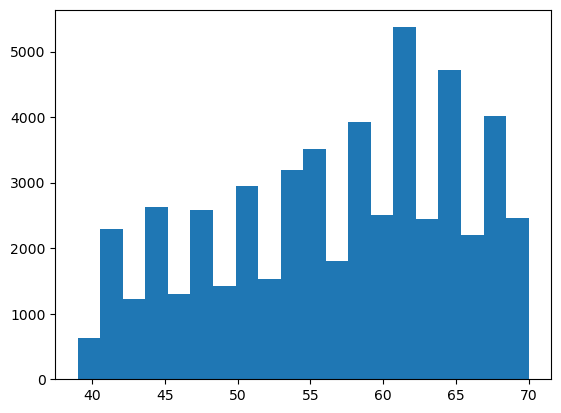

In [125]:
plt.hist(basic_info_filt[age_center.0.0].values,  bins = 20)

In [6]:
olink.head()

eid    Assay     NPX            Panel Panel_Lot_Nr  Assay_Version  \
0  1000181   AARSD1 -0.4305         Oncology       B04412            1.0   
1  1000181  ABHD14B -0.3222        Neurology       B04414            1.0   
2  1000181     ABL1 -0.3300         Oncology       B04412            1.0   
3  1000181    ACAA1 -0.5217         Oncology       B04412            1.0   
4  1000181     ACAN -0.4388  Cardiometabolic       B04413            1.0   

        PlateID WellID  Batch     LOD Processing_StartDate  Instance  
0  8.900000e+11    D08    3.0 -5.1861           2021-08-26         0  
1  8.900000e+11    D08    3.0 -4.1701           2021-08-26         0  
2  8.900000e+11    D08    3.0 -4.3769           2021-08-26         0  
3  8.900000e+11    D08    3.0 -1.2737           2021-08-26         0  
4  8.900000e+11    D08    3.0 -3.4464           2021-08-26         0

In [10]:
olink.shape

(231317856, 12)

In [21]:
instance23 = olink.loc[(olink[Instance] == 2) | (olink[Instance] == 3)]

In [18]:
# instance23 = instance23.dropna()

In [20]:
instance23.shape

(0, 12)

In [15]:
instance23.head()

eid    Assay     NPX            Panel Panel_Lot_Nr  \
77105952  1000181   AARSD1 -0.4305         Oncology       B04412   
77105953  1000181  ABHD14B -0.3222        Neurology       B04414   
77105954  1000181     ABL1 -0.3300         Oncology       B04412   
77105955  1000181    ACAA1 -0.5217         Oncology       B04412   
77105956  1000181     ACAN -0.4388  Cardiometabolic       B04413   

          Assay_Version  PlateID WellID  Batch  LOD Processing_StartDate  \
77105952            1.0      NaN    NaN    NaN  NaN                  NaN   
77105953            1.0      NaN    NaN    NaN  NaN                  NaN   
77105954            1.0      NaN    NaN    NaN  NaN                  NaN   
77105955            1.0      NaN    NaN    NaN  NaN                  NaN   
77105956            1.0      NaN    NaN    NaN  NaN                  NaN   

          Instance  
77105952         2  
77105953         2  
77105954         2  
77105955         2  
77105956         2

In [17]:
len(instance23["eid"].unique())

52704

In [22]:
asdf = olink.loc[(olink[eid] == 1000181) & (olink[Assay] == "AARSD1")]

In [23]:
asdf.head()

eid   Assay     NPX     Panel Panel_Lot_Nr  Assay_Version  \
0          1000181  AARSD1 -0.4305  Oncology       B04412            1.0   
77105952   1000181  AARSD1 -0.4305  Oncology       B04412            1.0   
154211904  1000181  AARSD1 -0.4305  Oncology       B04412            1.0   

                PlateID WellID  Batch     LOD Processing_StartDate  Instance  
0          8.900000e+11    D08    3.0 -5.1861           2021-08-26         0  
77105952            NaN    NaN    NaN     NaN                  NaN         2  
154211904           NaN    NaN    NaN     NaN                  NaN         3

In [19]:
len(olink["eid"].unique())

52704

In [25]:
olink.isna().sum()

eid                             0
Assay                           0
NPX                       6675936
Panel                      632448
Panel_Lot_Nr               632448
Assay_Version              632448
PlateID                 150993304
WellID                  150993304
Batch                   150993304
LOD                     151550859
Processing_StartDate    154235312
Instance                        0
dtype: int64